In [18]:
import numpy as np
import math
import cmath 
import matplotlib.pyplot as plt
import pandas as pd
import sys
import scipy.io.wavfile
from scipy.fftpack import dct
import sys
from sklearn import mixture
# from sklearn.externals import joblib
import glob
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import librosa
import IPython.display as ipd
import librosa.display
import scipy.stats as st
import matplotlib.axes as axes

# Implementations of the more complex algorithms such as deltas and filterbanks have been assissted by the following implementations:
#https://github.com/jameslyons/python_speech_features
#http://jamesmontgomery.us/blog/Voice_Recognition_Model.html

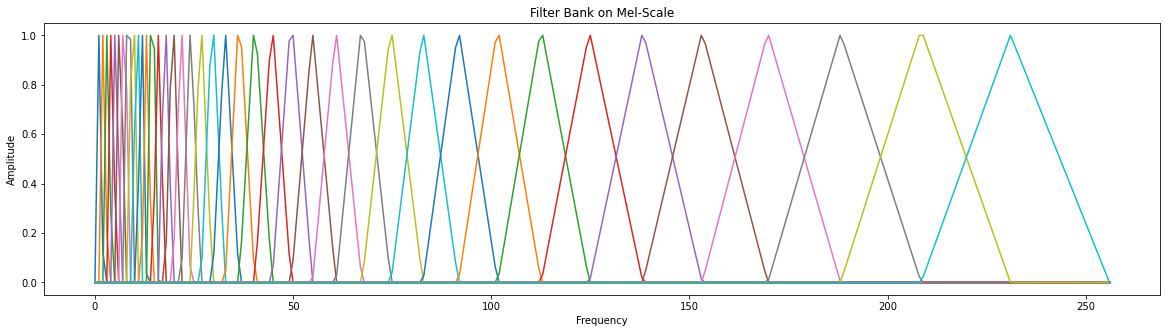

In [4]:
def plot_fb(sample_rate):    
    
    mels = librosa.filters.mel(sr=sample_rate, n_fft=512, n_mels=40,fmin=0, fmax=sample_rate / 2)
    mels /= np.max(mels, axis=-1)[:, None]

    plt.figure(figsize=(20,5))
    plt.plot(mels.T)
    plt.title("Filter Bank on Mel-Scale")
    plt.ylabel("Amplitude")
    plt.xlabel("Frequency")
    plt.show()
plot_fb(sample_rate)

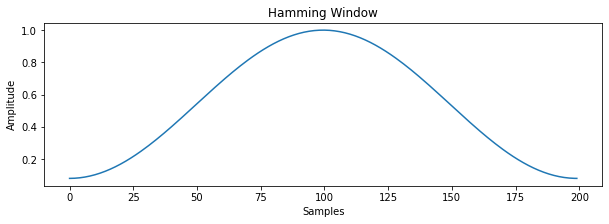

In [5]:
def plot_hamming():

    plt.figure(figsize=(10,3))
    plt.plot(np.hamming(200))
    plt.title('Hamming Window')
    plt.ylabel('Amplitude')
    plt.xlabel('Samples')
    plt.show()

plot_hamming()

In [6]:
def hz_to_mel(hz):
    if hz+1==0:
        raise ValueError("Taking log of zero")
    mel = 2595 * np.log10(1+hz/700)
    return mel

def mel_to_hz(mel):
    
    hz = 700*(10**(mel/2595.0)-1)
    return hz

def pre_emphasis(signal, coeff=0.95):
    
    emph_signal = np.append(signal[0], signal[1:] - coeff * signal[:-1])
    return emph_signal

In [7]:
def frames(sample_rate, emph_signal, frame_size=0.025, frame_stride=0.01):
    
    frame_length = frame_size * sample_rate
    frame_step = frame_stride * sample_rate
    signal_length = len(emph_signal)
    frame_length = int(frame_length)
    frame_step = int(frame_step)
    
    num_frames = int(np.ceil(float(abs(signal_length - frame_length)) / frame_step))
    pad_signal_length = num_frames * frame_step + frame_length
    pad_signal_length = int(pad_signal_length)
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emph_signal, z) 
    
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    
    return frames, frame_length

def hamming(frames, frame_length):
    
    frames *= np.hamming(frame_length)
    
    return frames

def spectrum(frames, NFFT=512):
    
    magspec = np.real(np.fft.rfft(frames, NFFT)) # Gives absolute value of fast fourier transform
    powspec = ((1/NFFT) * (magspec**2))          # Gives the power spectrum
    
    return powspec

In [8]:
def filterbanks(sample_rate, powspec, num_filt=20, NFFT=512, lowfreq=0, highfreq=None):
    
    highfreq = highfreq or sample_rate/2
    low_mel = hz_to_mel(lowfreq)
    high_mel = hz_to_mel(highfreq)
    
    mel_points = np.linspace(low_mel, high_mel, num_filt+2)
    hz_points = mel_to_hz(mel_points)
    
    bin = np.floor((NFFT+1) * hz_points / sample_rate)
    fbank = np.zeros((num_filt, int(np.floor(NFFT / 2 + 1))))

    for m in range(1, num_filt + 1):
        f_m_minus = int(bin[m - 1])   
        f_m = int(bin[m])             
        f_m_plus = int(bin[m + 1])    

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    
    filter_banks = np.dot(powspec, fbank.T)
    filter_banks = np.where(filter_banks == 0,np.finfo(float).eps,filter_banks) # prevents taking log of 0
    filter_banks = 20 * np.log10(filter_banks)
    
    return filter_banks


In [9]:
def mfcc(filter_banks, num_ceps=13, cep_lifter=22):
    
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 1-13
    (num_frames, num_coeff) = mfcc.shape
    n = np.arange(num_coeff)
    lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
    mfcc *= lift
    return mfcc

def normalisation(signal):
    
    v_multiplier = 0.05
    v_range = 100
    energy = [ s**2 for s in signal]
    v_threshold = v_multiplier*np.mean(energy)
    clean_samples=[0]

    for samples in range(0,len(signal)-v_range,v_range):
        sample_thresh = np.mean(energy[samples:samples+v_range])
        if sample_thresh>v_threshold:
            clean_samples.extend(signal[samples:samples+v_range])

    signal = np.array(clean_samples)
    return signal

def deltas(mfcc):
    
    deltas = np.zeros(mfcc.shape)
    for t in range(deltas.shape[1]):
        index_t_minus_one,index_t_plus_one=t-1,t+1

        if index_t_minus_one<0:    
            index_t_minus_one=0
        if index_t_plus_one>=deltas.shape[1]:
            index_t_plus_one=deltas.shape[1]-1

        deltas[:,t]=0.5*(mfcc[:,index_t_plus_one]-mfcc[:,index_t_minus_one])
    
    double_deltas = np.zeros(mfcc.shape)
    for t in range(double_deltas.shape[1]):

        index_t_minus_one,index_t_plus_one, index_t_plus_two,index_t_minus_two=t-1,t+1,t+2,t-2

        if index_t_minus_one<0:
            index_t_minus_one=0
        if index_t_plus_one>=deltas.shape[1]:
            index_t_plus_one=deltas.shape[1]-1
        if index_t_minus_two<0:
            index_t_minus_two=0
        if index_t_plus_two>=deltas.shape[1]:
            index_t_plus_two=deltas.shape[1]-1

        double_deltas[:,t]=0.1*( 2*mfcc[:,index_t_plus_two]+mfcc[:,index_t_plus_one]
                                    -mfcc[:,index_t_minus_one]-2*mfcc[:,index_t_minus_two] )
    
    return deltas, double_deltas

In [10]:
def function(path):
    
    signal, sample_rate = librosa.core.load(path)
    signal = normalisation(signal)
    frame, frame_length = frames(sample_rate=sample_rate, emph_signal=pre_emphasis(signal,0.95))
    frame = hamming(frame, frame_length)
    
    powspec = spectrum(frame)
    
    filter_banks = filterbanks(sample_rate=sample_rate, powspec=powspec)
    
    mfcc_13 = mfcc(filter_banks=filter_banks)
    deltas_13, double_deltas = deltas(mfcc_13)
    
    combined_feat = np.concatenate((mfcc_13, deltas_13, double_deltas), axis=1)
    return combined_feat

In [13]:
import os
import cv2
from scipy.spatial import distance

# dst = distance.euclidean(speaker_1[0], speaker_1[1])
# dst2 = distance.euclidean(speaker_1[0], speaker_2[1])
# print(dst, dst2)
# plt.figure(figsize=(12, 4))
# plt.plot(speaker_1[0], color='black')
# plt.plot(speaker_1[1], color='blue')
# plt.plot(speaker_2[1], color='red')

In [19]:
directory = '/Users/abuzy/Documents/$data/Uzayr/Higher Education/Machine Learning/Dataset'

# Folders where the sound files are stored
df_2 = ["Train2",
        "True2",
        "Test False"
]

In [16]:
def evaluation(directory, df):    

    df_train = [] 

    path_train = os.path.join(directory, df[0])
    path_true = os.path.join(directory, df[1])
    path_false = os.path.join(directory, df[2])
    
    for file in os.listdir(path_train):
        train_path = os.path.join(path_train, file)
        train_feat = function(train_path)
        mean_train = np.mean(train_feat.T, axis=1)    #Average of the features to get a single line for each sound file
        df_train.append(mean_train)
    
    df_train = np.array(df_train)
    df_train = df_train.T
    train_value = np.mean(df_train, axis=1)   # Average the combined features of all the training files so we can calculate the euclidean distance (see below)
    
#     plt.figure(figsize=(12, 4))
#     plt.ylim(-150, 150)
#     plt.plot(df_train)
#     plt.figure(figsize=(12, 4))
#     plt.ylim(-200, 150)
#     plt.title('Training')
#     plt.plot(train_value, color='r')
    
#     plt.figure(figsize=(12, 4))
#     plt.ylim(-200, 150)
#     plt.title('Trained User')


# Calculates the distance between the combined features for each sound file and the features for the trained sound file: 
    file_length = 0
    dst = []
    for file2 in os.listdir(path_true):
        true_path = os.path.join(path_true, file2)
        true_feat = function(true_path)
        mean_true = np.mean(true_feat.T, axis=1)            
        dist = distance.euclidean(train_value, mean_true) #
        file_length += 1
        if dist>220:
            dst.append(dist)
            
        print("True", dist)
#         plt.plot(mean_true)
    
    false_rejec = (len(dst) / file_length ) * 100   
    true_accep = 100 - false_rejec
        
#     plt.figure(figsize=(12, 4))
#     plt.ylim(-200, 150)
#     plt.title('Other Users')

    file_length2 = 0
    dst2 = []
    
    for file3 in os.listdir(path_false):
        false_path = os.path.join(path_false, file3)
        false_feat = function(false_path)
        mean_false = np.mean(false_feat.T, axis=1)
        dist2 = distance.euclidean(train_value, mean_false)
        print("False", dist2)       
#         plt.plot(mean_false)
        
        file_length2 += 1
        if dist2<=220: # This value will need to be adjusted per voice as the output features will give different values 
            dst2.append(dist2)
    
    false_accep = (len(dst2) / file_length2) * 100        
    true_rejec = 100 - false_accep
    success_rate = 100 - ((len(dst)+len(dst2)) * 100 / (file_length+file_length2))
    
    print("The True Acceptance Rate is", true_accep)
    print("The True Rejection Rate is", true_rejec)
    print("The Success Rate is", success_rate)
#first 35
evaluation(directory, df_2)

True 143.88219916397765
True 121.95127331395736
True 142.75157864798936
True 155.95166985006097
True 176.19303867257165
True 153.45493828477723
True 156.21624651893978
True 219.93536441516352
True 150.06806252168437
True 138.24907670737772
True 139.69704026257926
True 263.8029961395424
True 274.97022528136426
True 242.73606483034825
True 272.3117863348133
True 122.59093667564885
True 57.30686647512306
True 71.0585047193551
True 87.92993243023126
True 141.45748980316415
True 176.47001623740994
True 130.0189209573917
True 134.37034852261823
True 230.22005738912856
True 215.17883687954452
True 118.46830936482704
True 164.77816665554627
True 303.27579149998684
True 274.31038168403177
True 400.24811312411225
True 416.3450627363429
True 170.0752333402731
True 101.88408429317116
True 100.44814298887417
True 126.77001367528746
True 324.43788692186473
True 334.8450004442547
True 365.60581977620467
True 396.062989718943
True 130.01081074503205
True 161.8759165551573
True 147.4598324165851
True 1